# Mnist by using CNN

In [1]:
from autograd import grad as compute_grad   
import autograd.numpy as np
import numpy as npo
import copy
from autograd import grad as compute_grad   
from datetime import datetime 

#this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## 1) load the MNIST dataset

The function of load_mnist is used to load the picture dataset which each orignal image is 28 x 28. 

In [2]:
import os, struct
from array import array as pyarray 
from numpy import append, array, int8, uint8, zeros

def load_mnist(dataset="training", digits=None, path=None, asbytes=False, selection=None, return_labels=True, return_indices=False):
    """
    Loads MNIST files into a 3D numpy array.

    You have to download the data separately from [MNIST]_. It is recommended
    to set the environment variable ``MNIST`` to point to the folder where you
    put the data, so that you don't have to select path. On a Linux+bash setup,
    this is done by adding the following to your ``.bashrc``::

        export MNIST=/path/to/mnist

    Parameters
    ----------
    dataset : str 
        Either "training" or "testing", depending on which dataset you want to
        load. 
    digits : list 
        Integer list of digits to load. The entire database is loaded if set to
        ``None``. Default is ``None``.
    path : str 
        Path to your MNIST datafiles. The default is ``None``, which will try
        to take the path from your environment variable ``MNIST``. The data can
        be downloaded from http://yann.lecun.com/exdb/mnist/.
    asbytes : bool
        If True, returns data as ``numpy.uint8`` in [0, 255] as opposed to
        ``numpy.float64`` in [0.0, 1.0].
    selection : slice
        Using a `slice` object, specify what subset of the dataset to load. An
        example is ``slice(0, 20, 2)``, which would load every other digit
        until--but not including--the twentieth.
    return_labels : bool
        Specify whether or not labels should be returned. This is also a speed
        performance if digits are not specified, since then the labels file
        does not need to be read at all.
    return_indicies : bool
        Specify whether or not to return the MNIST indices that were fetched.
        This is valuable only if digits is specified, because in that case it
        can be valuable to know how far
        in the database it reached.

    Returns
    -------
    images : ndarray
        Image data of shape ``(N, rows, cols)``, where ``N`` is the number of images. If neither labels nor inices are returned, then this is returned directly, and not inside a 1-sized tuple.
    labels : ndarray
        Array of size ``N`` describing the labels. Returned only if ``return_labels`` is `True`, which is default.
    indices : ndarray
        The indices in the database that were returned.

    Examples
    --------
    Assuming that you have downloaded the MNIST database and set the
    environment variable ``$MNIST`` point to the folder, this will load all
    images and labels from the training set:

    >>> images, labels = ag.io.load_mnist('training') # doctest: +SKIP

    Load 100 sevens from the testing set:    

    >>> sevens = ag.io.load_mnist('testing', digits=[7], selection=slice(0, 100), return_labels=False) # doctest: +SKIP

    """

    # The files are assumed to have these names and should be found in 'path'
    files = {
        'training': ('train-images-idx3-ubyte', 'train-labels-idx1-ubyte'),
        'testing': ('t10k-images-idx3-ubyte', 't10k-labels-idx1-ubyte'),
    }

    if path is None:
        try:
            path = os.environ['MNIST']
        except KeyError:
            raise ValueError("Unspecified path requires environment variable $MNIST to be set")

    try:
        images_fname = os.path.join(path, files[dataset][0])
        labels_fname = os.path.join(path, files[dataset][1])
    except KeyError:
        raise ValueError("Data set must be 'testing' or 'training'")

    # We can skip the labels file only if digits aren't specified and labels aren't asked for
    if return_labels or digits is not None:
        flbl = open(labels_fname, 'rb')
        magic_nr, size = struct.unpack(">II", flbl.read(8))
        labels_raw = pyarray("b", flbl.read())
        flbl.close()

    fimg = open(images_fname, 'rb')
    magic_nr, size, rows, cols = struct.unpack(">IIII", fimg.read(16))
    images_raw = pyarray("B", fimg.read())
    fimg.close()

    if digits:
        indices = [k for k in range(size) if labels_raw[k] in digits]
    else:
        indices = range(size)

    if selection:
        indices = indices[selection] 
    N = len(indices)

    images = zeros((N, rows, cols), dtype=uint8)

    if return_labels:
        labels = zeros((N), dtype=int8)
    for i, index in enumerate(indices):
        images[i] = array(images_raw[ indices[i]*rows*cols : (indices[i]+1)*rows*cols ]).reshape((rows, cols))
        if return_labels:
            labels[i] = labels_raw[indices[i]]

    if not asbytes:
        images = images.astype(float)/255.0

    ret = (images,)
    if return_labels:
        ret += (labels,)
    if return_indices:
        ret += (indices,)
    if len(ret) == 1:
        return ret[0] # Don't return a tuple of one
    else:
        return ret


### Load images of one number

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


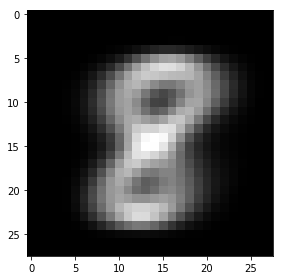

In [3]:
import matplotlib.pyplot as plt
#import numpy as np
#from mnist import load_mnist
%matplotlib inline

images, labels = load_mnist(digits=[8], path='.')
#Displaying the mean image for digit 8.
plt.imshow(images.mean(axis=0), cmap = 'gray')
plt.show()

In [4]:
from autograd import grad as compute_grad   
import autograd.numpy as np
import numpy as npo
import copy
from datetime import datetime 

#this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

# Tensor-based version for CNN

                                                                                                                       There are ten classes for all the dataset, the cost function is softmax which is adjust to 10-class classifier. Also, the count function and predict function are modified.  

In [11]:
class tensor_conv_layer:
    def load_data(self,x,y):
        self.x = x
        self.y = y
    
    # convolution function
    def conv_function(self,tensor_window):
        tensor_window = np.reshape(tensor_window,(np.shape(tensor_window)[0],np.shape(tensor_window)[1]*np.shape(tensor_window)[2]))
        t = np.dot(self.kernels,tensor_window.T)
        return t

    # pooling / downsampling parameters
    def pool_function(self,tensor_window):
        t = np.max(tensor_window,axis = (1,2))
        return t

    # activation 
    def activation(self,tensor_window):
        return np.maximum(0,tensor_window)

    # pad image with appropriate number of zeros for convolution
    def pad_tensor(self,tensor,kernel_size):
        odd_nums = np.array([int(2*n + 1) for n in range(100)])
        pad_val = np.argwhere(odd_nums == kernel_size)[0][0]
        tensor_padded = np.zeros((np.shape(tensor)[0], np.shape(tensor)[1] + 2*pad_val,np.shape(tensor)[2] + 2*pad_val))
        tensor_padded[:,pad_val:-pad_val,pad_val:-pad_val] = tensor
        return tensor_padded    
    
    # sliding window for image augmentation
    def sliding_window_tensor(self,tensor,window_size,stride,func):
        # grab image size, set container for results
        image_size = np.shape(tensor)[1]
        results = []
        
        # slide window over input image with given window size / stride and function
        for i in np.arange(0, image_size - window_size + 1, stride):
            for j in np.arange(0, image_size - window_size + 1, stride):
                # take a window of input tensor
                tensor_window =  tensor[:,i:i+window_size, j:j+window_size]
                
                # now process entire windowed tensor at once
                tensor_window = np.array(tensor_window)
                yo = func(tensor_window)

                # store weight
                results.append(yo)
        
        # re-shape properly
        results = np.array(results)
        results = results.swapaxes(0,1)
        if func == self.conv_function:
            results = results.swapaxes(1,2)

        ##results = np.reshape(results,(np.shape(results)[0]*np.shape(results)[1],np.shape(results)[2]*np.shape(results)[3]))   
        # return results in numpy array format
        return results 

    # make feature map
    def make_feature_tensor(self,tensor):
        # create feature map via convolution --> returns flattened convolution calculations
        conv_stride = 1
        feature_tensor = self.sliding_window_tensor(tensor,self.kernel_size,conv_stride,self.conv_function) 

        # re-shape convolution output ---> to square of same size as original input
        num_filters = np.shape(feature_tensor)[0]
        num_images = np.shape(feature_tensor)[1]
        square_dim = int((np.shape(feature_tensor)[2])**(0.5))
        feature_tensor = np.reshape(feature_tensor,(num_filters,num_images,square_dim,square_dim))
        
        # shove feature map through nonlinearity
        feature_tensor = self.activation(feature_tensor)

        # pool feature map --- i.e., downsample it
        pool_stride = 3
        pool_window_size = 6
        downsampled_feature_map = []
        for t in range(np.shape(feature_tensor)[0]):
            temp_tens = feature_tensor[t,:,:,:]
            d = self.sliding_window_tensor(temp_tens,pool_window_size,pool_stride,self.pool_function)
            downsampled_feature_map.append(d)
        downsampled_feature_map = np.array(downsampled_feature_map)

        # return downsampled feature map --> flattened
        return downsampled_feature_map

    # our normalization function
    def normalize(self,data,data_mean,data_std):
        normalized_data = (data - data_mean)/(data_std + 10**(-5))
        return normalized_data

    # convolution layer
    def conv_layer(self,tensor,kernels):
        #### prep input tensor #####
        # pluck out dimensions for image-tensor reshape
        num_images = np.shape(tensor)[0]
        num_kernels = np.shape(kernels)[0]
        
        # create tensor out of input images (assumed to be stacked vertically as columns)
        tensor = np.reshape(tensor,(np.shape(tensor)[0],int((np.shape(tensor)[1])**(0.5)),int( (np.shape(tensor)[1])**(0.5))),order = 'F')

        # pad tensor
        kernel = kernels[0]
        self.kernel_size = np.shape(kernel)[0]
        padded_tensor = self.pad_tensor(tensor,self.kernel_size)

        #### prep kernels - reshape into array for more effecient computation ####
        self.kernels = np.reshape(kernels,(np.shape(kernels)[0],np.shape(kernels)[1]*np.shape(kernels)[2]))
        
        #### compute convolution feature maps / downsample via pooling one map at a time over entire tensor #####
        # compute feature map for current image using current convolution kernel
        feature_tensor = self.make_feature_tensor(padded_tensor)

        feature_tensor = feature_tensor.swapaxes(0,1)
        feature_tensor = np.reshape(feature_tensor, (np.shape(feature_tensor)[0],np.shape(feature_tensor)[1]*np.shape(feature_tensor)[2]),order = 'F')
        
        return feature_tensor
    
    def predict(self,x,w):
        # pass input data through convolutional layer
        x_conv = self.conv_layer(x,w[0])
        
        # take inner product against output of conv layer
        value=np.dot(x_conv,w[1][1:,:])
        for line in value:
            line+=w[1][0,:]
        return np.array(value)
    
    # the softmax cost function 
    def softmax(self,w):
        p=self.predict(x,w)
        cost=np.sum(np.max(p,axis=1)-np.array([p[i][y[i]] for i in range(len(y))]))+0.5*np.sum(np.square(w[1]))
        return cost
    
    def count(self,w):
        p=self.predict(x,w)
        return np.sum(np.sign(np.argmax(p,axis=1) - self.y)**2)

## Gradient Descent

In [6]:
from autograd.misc.flatten import flatten
from autograd.misc.flatten import flatten_func
# gradient descent function
def gradient_descent(g,w_unflat,alpha,max_its,version,**kwargs):
    verbose = False
    if 'verbose' in kwargs:
        verbose = kwargs['verbose']

    # flatten the input function, create gradient based on flat function
    g_flat, unflatten, w = flatten_func(g, w_unflat)
    grad = compute_grad(g)

    # record history
    w_hist = []
    w_hist.append(w_unflat)

    # over the line
    for k in range(max_its):   
        if verbose == True:
            if np.mod(k,5) == 0:
                print ('started step ' + str(k) + ' of ' + str(max_its))
                
        # plug in value into func and derivative
        grad_eval = grad(w_unflat)
        grad_eval, _ = flatten(grad_eval)

        ### normalized or unnormalized descent step? ###
        if version == 'normalized':
            grad_norm = np.linalg.norm(grad_eval)
            if grad_norm == 0:
                grad_norm += 10**-6*np.sign(2*np.random.rand(1) - 1)
            grad_eval /= grad_norm

        # take descent step 
        w = w - alpha*grad_eval

        # record weight update
        w_unflat = unflatten(w)
        w_hist.append(w_unflat)
        
    if verbose == True:
        print ('finished all ' + str(max_its) + ' steps')
#     if verbose == True:
#         print ('...optimization complete!')
#         time.sleep(1.5)
#         clear_output()

    return w_hist

In [7]:
images, labels = load_mnist(digits=range(0, 10), path='.')
x = np.array([v.flatten() for v in images])
y = labels
print(x.shape)

(60000, 784)


### Building a model 

In [13]:
# random initialization for kernels
scale = 0.1
kernels = scale*np.random.randn(8,3,3) 

# initialize instance of convnet
tensor_test = tensor_conv_layer()
tensor_test.load_data(x,y)

# run a small set of images through the network to collect final weights size
final_features = tensor_test.conv_layer(x,kernels)
final_size = np.shape(final_features)[1] + 1

# set final weights 
final_weights = scale*np.random.randn(final_size,10)# with respect to ten nodes in output layer 
weights = [kernels,final_weights]

Use gradient descent to train the model, the iteration is set as 2 due to the time limitation.

In [19]:
# run standard (full) gradient descent
g = tensor_test.softmax
w = weights
alpha = 10**(-1)
max_its = 2
version = 'normalized'
weight_history_1 =  gradient_descent(g,w,alpha,max_its,version,verbose = True)

started step 0 of 2
finished all 2 steps


In [20]:
# import plotting library and other necessities
import matplotlib.pyplot as plt
from matplotlib import gridspec
import copy

# our plotting function
def plot_history(x,y,weight_histories,soft,count):
    '''
    A module for computing / plotting the cost and misclassification histories for a given run of gradient descent.
    Here the input should be the data and weight history from a gradient descent run
    '''
    
    # initialize figure
    fig = plt.figure(figsize = (9,3))

    # create subplot with 3 panels, plot input function in center plot
    gs = gridspec.GridSpec(1, 2) 
    ax1 = plt.subplot(gs[0]); 
    ax2 = plt.subplot(gs[1]);
    
    # loop over histories and plot all
    c = 1
    for weight_history in weight_histories:
        # loop over input weight history and create associated cost and misclassification histories
        cost_history = []
        count_history = []
        for weight in weight_history:
            cost_val = soft(weight)
            cost_history.append(cost_val)

            count_val = count(weight)
            count_history.append(count_val)

        # now plot each, one per panel
        ax1.plot(cost_history)  
        label = 'full grad'
        if c == 2:
            label = 'mini-batch'
        if c == 3:
            label = 'stochastic'
        ax2.plot(count_history,label = label)
        c+=1
        
    # label each panel
    ax1.set_xlabel('iteration')
    ax1.set_ylabel('cost function val')
    ax1.set_title('cost function history')
    
    ax2.set_xlabel('iteration')
    ax2.set_ylabel('misclassifications')
    ax2.set_title('number of misclassificaions')
    
    ax2.legend()
    
    plt.show()

<IPython.core.display.Javascript object>


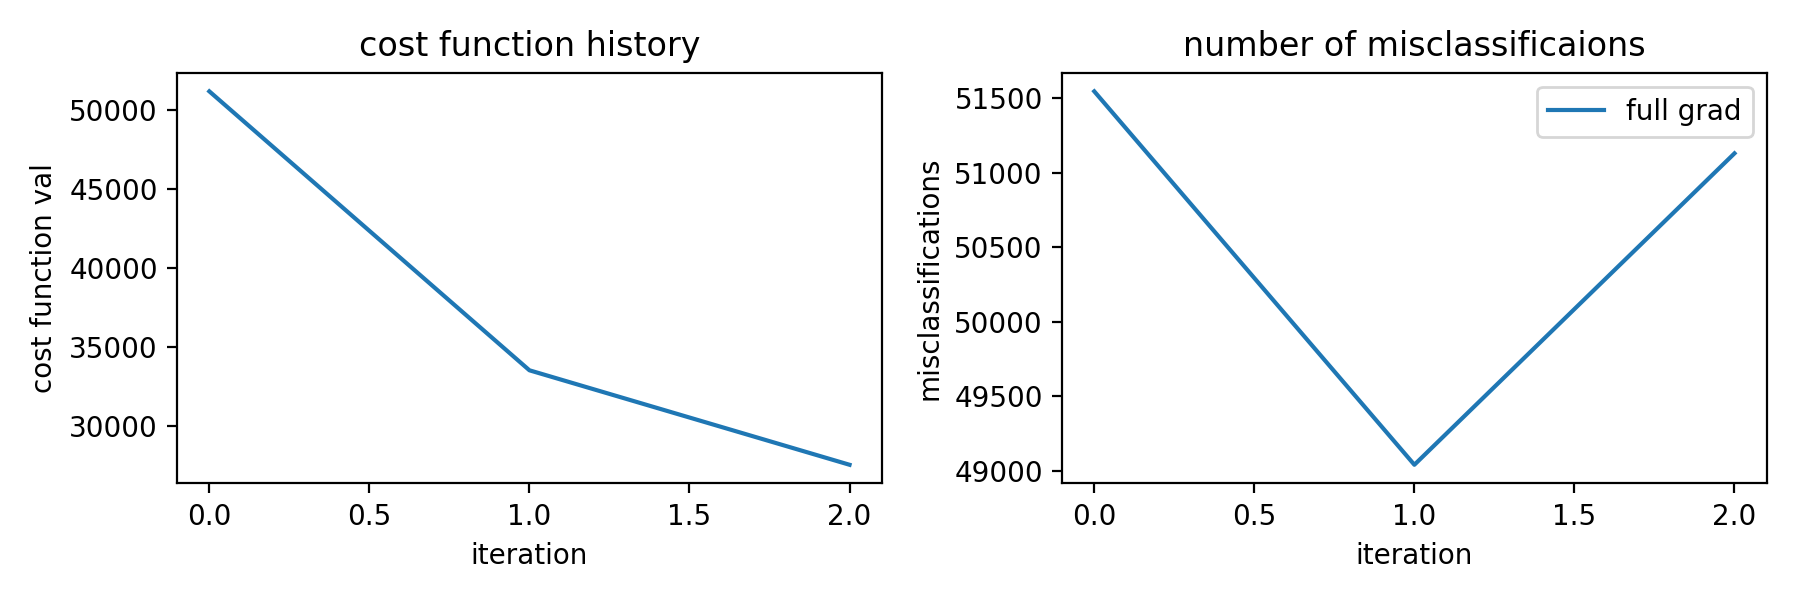

In [21]:
weight_histories = [weight_history_1]
plot_history(x,y,weight_histories,tensor_test.softmax,tensor_test.count)